# Exploration 9. 폐렴아 기다려라! 폐렴 진단기 성능 개선

본 과제는 대략 80% 정도의 정확도를 가진 X-RAY 사진 판독 폐렴 진단기를 90% 이상으로 끌어올리기 위한 개선 방안을 연구한다.

## 루브릭 평가 기준
1. 의료영상을 처리하는 `CNN` 기반 딥러닝 모델이 잘 구현되었다.<br>
   모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.<br>
2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.<br>
   `regularization`, `augmentation` 등의 기법의 사용 여부에 따른 모델 성능 측정이 `ablation study` 형태로 체계적으로 수행되었다.<br>
3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.<br>
   Accuracy 기준 85%에 도달하였다.<br>

* * *

## Chest X-Ray Images Dataset from Kaggle
* 중국 광저우에 있는 광저우 여성 및 어린이 병원의 1~5세 소아 환자의 흉부 X선 영상 데이터셋
* `~/aiffel/chest_xray_data` 하위에 3개의 폴더(`train`, `test`, `val`)로 구성
* 각 이미지 카테고리(폐렴/정상)에 대한 하위 폴더를 포함
* 5,856개의 `X-RAY` 이미지(JPEG)와 2개의 범주(폐렴/정상)
* 총 1.2GB 가량의 데이터 크기

* * *

## X-Ray 이미지를 이용한 폐렴 구별법
* `폐렴(pneumonia)`<br>
  * 폐에 염증이 생긴 상태로, 중증의 호흡기 감염병<br>
  * 세균을 통한 감염이 가장 많으며, 바이러스, 균류, 또는 기타 미생물도 원인이 될 수 있음<br>
  * 드물게는 알레르기 반응이나 자극적인 화학 물질을 흡입해 발생하기도 함<br>
  * 오늘날에는 적절한 의학적 치료로 폐렴 환자의 95% 이상이 회복되나, 일부 저개발국(개발 도상국)에서는 주요 사망 원인 중 하나<br>
* 폐렴을 구별하는 법<br>
  <img src="https://d3s0tskafalll9.cloudfront.net/media/original_images/11_l7pucvb.png"><br>
  * X-RAY 사진상, 다양한 양상의 음영(폐 부위에 희미한 그림자) 증가가 관찰됨<br>
  <img src="https://d3s0tskafalll9.cloudfront.net/media/original_images/12_e0QcAmT.png"><br>
  * 정상적인 흉부 X-RAY(왼쪽) : 비정상적 음영 영역이 없는 깨끗한 폐<br>
  * 세균성 폐렴(가운데) : 일반적으로 오른쪽 상부 엽(흰색 화살표)에 있는 부분을 나타냄<br>
  * 바이러스성 폐렴(오른쪽) : 양쪽 폐에서보다 확산된 interstitial(조직 사이에 있는) 패턴으로 나타남<br>

* * *

## 1. 실험 환경 Set-up


In [2]:
# 실습에서 사용할 패키지(라이브러리) import

import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [23]:
# 실습에 필요한 변수 생성

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 아래의 두 변수를 변경함으로써 90% 이상의 정확도에 도달하도록 한다.
BATCH_SIZE = 10
EPOCHS = 19

print(ROOT_PATH)

/aiffel/aiffel


## 2. 데이터 가져오기

In [24]:
# 데이터를 가져와 각 데이터들의 개수를 체크
# 데이터를 열어보면 이미 train, validation, test로 나누어져 있음

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [25]:
# train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [26]:
# train 데이터 내 정상 이미지 수와 폐렴 이미지 수 확인

print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [27]:
# 파일 경로에 정상 이미지와 폐렴 이미지 수 확인

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


* 정상보다 폐렴 이미지 수가 3배 더 많이 있음이 확인됨
* `CNN` 모델의 경우 데이터가 클래스별 Balance가 좋을수록 잘 트레이닝 할 수 있음
* `test`와 `val` 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 무관하므로 imbalance한 데이터셋이어도 무관

* `tf.data` 인스턴스 생성
  * `tensorflow`에서 학습시킬 때, `mini-batch`로 작업할 수 있도록 해 줌
  * 이로 인해서 학습 데이터를 효율적으로 사용할 수 있게 됨
  * [`mini-batch`](https://acdongpgm.tistory.com/202)
    * batch size를 1 또는 max가 아닌 적당한 값을 정해서 최적화하는 방법
    * 설계자의 의도에 따라 속도와 안정성을 동시에 관리할 수 있으며, GPU 기반의 효율적인 병렬 연산이 가능해짐

In [28]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [29]:
# Train 데이터셋, validation 데이터셋 개수 확인

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [30]:
# 파일 경로에 포함된 NORMAL이나 PNEUMONIA를 이용해 라벨 데이터를 만들어 주는 함수 생성
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

* `decode_img` 함수와 `process_path` 함수 생성
  * 이미지 사이즈는 현실적으로 제각각의 사이즈를 가질 가능성이 높음
  * 이미지의 사이즈를 통일시키고 `GPU` 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄임

In [31]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

* `train` `validation` 데이터셋 생성<br>
  `num_parallel_calls` 파라미터에 위에서 할당한 `AUTOTUNE` 변수를 이용함으로써 더욱 빠르게 데이터를 처리할 수 있음

In [32]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [33]:
# 이미지가 잘 리사이즈 되었고 라벨이 잘 삽입되었는지 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [34]:
# test 데이터셋 생성 후 데이터 개수 확인

test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


* `tf.data` 파이프라인을 이용하여 `prepare_for_training()` 함수를 정의해서 데이터 변환
  - `shuffle()`
    - 고정 크기 버퍼 유지
    - 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
  - `repeat()`
    - `epoch`를 진행하면서 여러 번 데이터셋을 로드
    - 이때 `repeat()`를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 함
    - ex) 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요
    → `repeat()` 사용 시 자동으로 데이터를 맞춰 줌
  - `batch()`
    - `BATCH_SIZE`에서 정한 만큼의 배치로 주어짐
    - ex) 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 분할됨
  - `prefetch()`
    - 학습 데이터를 나눠서 읽어옴
    - 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비
    - 리소스의 유휴 상태를 줄일 수 있음

In [35]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 3. 데이터 시각화
  * `train`에 있는 `batch` 중 첫 번째 배치를 추출
  * 추출된 배치를 `image`와 `label` 데이터셋으로 분할
  * `show_batch()` 함수를 이용해서 결과 사진 출력
  * 본 실습에서는 `augmentation`을 시도하였으므로, 좌우 반전이 제대로 처리되었는지 확인

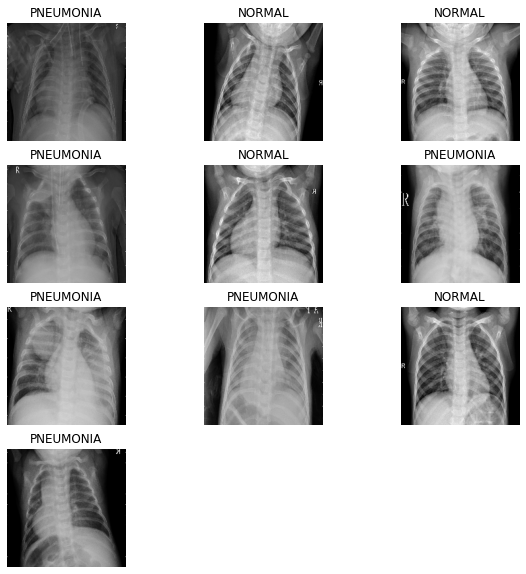

In [36]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 4. [CNN 모델링](http://taewan.kim/post/cnn/)
  * `Convolution Block` 생성
    * `conv_block()`의 구성
      * `Convolution`을 두 번 진행
      * `Batch Normalization`을 통해서 `Gradient Vanishing`, `Gradient Exploding` 해결
      * `Max Pooling` 수행
    * `Dense Block` 생성

In [37]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

* 해당 모델은 두 가지 `regularization` 기법을 사용
  * `Batch Normalization`과 `Dropout` 기법을 동시에 사용
  * 한 논문에서는 일반적으로 이런 방법은 잘 사용되지 않거나 금기시하는 경우가 있는데, `variance shift`를 억제하는 `Batch Normalization`과 이를 유발하는 `Dropout`을 동시에 사용하는 것이 어울리지 않는다고 언급 [링크](https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf)  
  * 반면, 실용적으로 동시에 사용하는 것이 성능 향상에 도움을 주는 경우가 실제로 존재함 [링크](https://arxiv.org/pdf/1905.05928.pdf)

In [38]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 5. 데이터 imbalance 처리
* `Weight Balancing`
  * `training set`의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법
  * `Keras`는 `model.fit()`을 호출할 때 파라미터로 넘기는 `class_weight`에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있음
* `weight_for_0` `Normal` 이미지에 사용할 weight
* `weight_for_1` `Pneumonia` 이미지에 사용할 weight    
  → 이 weight들은 `Normal`과 `Pneumonia` 전체 데이터 건수에 반비례하게 설정됨


In [39]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


## 6. 모델 훈련
  * `GPU`를 이용한 이미지 훈련
  * 모델은 위에서 만들었던 모델 함수인 `build_model()`을 model에 선언
  * 이미지의 라벨이 두 개 밖에 없기 때문에 `binary_cross entropy` loss를 사용
  * optimizer로 `adam`을 사용
  * 성과에 대해 측정하기 위한 metrics
    * `accuracy`
    * `precision`
    * `recall`
  * 각 파라미터에 위에서 선언한 변수와 데이터셋을 가져온 뒤 각각에 맞게 입력하여 모델 `fit`

In [40]:
# image training
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

# model fitting
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/19
418/418 [==============================] - 58s 119ms/step - loss: 0.4373 - accuracy: 0.7861 - precision: 0.9390 - recall: 0.7621 - val_loss: 0.9525 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/19
418/418 [==============================] - 50s 119ms/step - loss: 0.2695 - accuracy: 0.8878 - precision: 0.9687 - recall: 0.8774 - val_loss: 0.1187 - val_accuracy: 0.9644 - val_precision: 0.9607 - val_recall: 0.9921
Epoch 3/19
418/418 [==============================] - 49s 117ms/step - loss: 0.2656 - accuracy: 0.8914 - precision: 0.9656 - recall: 0.8855 - val_loss: 0.0923 - val_accuracy: 0.9673 - val_precision: 0.9854 - val_recall: 0.9699
Epoch 4/19
418/418 [==============================] - 50s 119ms/step - loss: 0.2164 - accuracy: 0.9117 - precision: 0.9741 - recall: 0.9055 - val_loss: 0.1495 - val_accuracy: 0.9442 - val_precision: 0.9972 - val_recall: 0.9266
Epoch 5/19
418/418 [==============================] - 50s 121ms/step - loss: 0.2255 - accura

## 7. 결과 확인 및 시각화

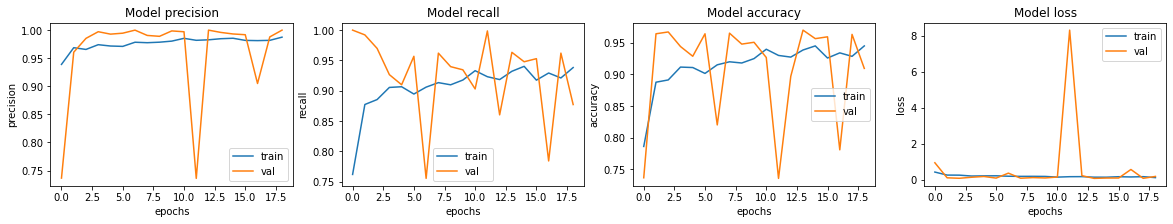

In [41]:
# 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 확인

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [42]:
# 테스트 데이터로 모델 평가를 위해 loss, accuracy, precision, recall 값을 출력

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

63/63 [==============================] - 5s 74ms/step - loss: 0.5339 - accuracy: 0.8686 - precision: 0.8684 - recall: 0.9308
Loss: 0.5338807702064514,
Accuracy: 0.8685897588729858,
Precision: 0.8684210777282715,
Recall: 0.9307692050933838


## 8. 변수값에 따른 정확도 확인
1. 1차 시도<br>
   Loss: 1.6293398141860962<br>
   Accuracy: 0.7259615659713745<br>
   Precision: 0.6951871514320374<br>
   Recall: 1.0<br>
2. 2차 시도<br>
   Loss: 0.8677995204925537<br>
   Accuracy: 0.7724359035491943<br>
   Precision: 0.7375478744506836<br>
   Recall: 0.9871794581413269<br>
3. 3차 시도<br>
   Loss: 0.8358023166656494<br>
   Accuracy: 0.8060897588729858<br>
   Precision: 0.772819459438324<br>
   Recall: 0.9769230484962463
4. 4차 시도<br>
   Loss: 0.7128326296806335<br>
   Accuracy: 0.7884615659713745<br>
   Precision: 0.7549406886100769<br>
   Recall: 0.9794871807098389<br>
5. 5차 시도<br>
   Loss: 0.5338807702064514<br>
   Accuracy: 0.8685897588729858<br>
   Precision: 0.8684210777282715<br>
   Recall: 0.9307692050933838

* * *

## 회고
* 5번의 하이퍼파라미터 수정 끝에 루브릭 평가 기준에 맞게 85% 이상의 accuracy 정확도를 보였으나, 코드 구조 자체에 대해서 개선하지 않고 일일이 값을 수정하는 방식에 의존했기 때문에 사실상 매우 비효율적인 방식으로 진행했다고 생각한다. 박창근 퍼실님이 알려준 드롭아웃 기법을 사용하려 했으나, 해당 이론에 대한 이해가 미흡하여 적용하지 못했던 점이 아쉽다.
* 의료 영상 이미지 분석의 경우는 다른 이미지 분석과 다르게 인체와 의학에 관해 전문적인 지식을 가지고 있는 사람이 작업을 하여야 하는데, 프로젝트를 수행하면서 인체와 의학에 관한 짧은 지식 습득만으로 정확히 데이터를 분석할 수 있는지 의문이 들었다. 관련 지식이 전혀 없는 상태에서 최소한의 가이드만으로 의학적 전문 지식이 필요한 데이터를 분석하는 부분에 대한 한계가 있음을 명확히 인지하게 되었다.